# imports

In [1]:
import igraph as ig
import numpy as np
import pandas as pd

import seaserpent as ss
%env SEATABLE_TOKEN = 59481ea08c6a2ff4f3635ea54199520ce1a0f1dd
%env SEATABLE_SERVER = https://flytable.mrc-lmb.cam.ac.uk/

import matplotlib.pyplot as plt

env: SEATABLE_TOKEN=59481ea08c6a2ff4f3635ea54199520ce1a0f1dd
env: SEATABLE_SERVER=https://flytable.mrc-lmb.cam.ac.uk/


In [32]:
# grab from info table
table = ss.Table(table='info', base='main').to_frame().reset_index()

In [33]:
# re-sort the table so the index of the table is root that will show up in the graph
label_df = table.set_index(table.root_630.astype(str)).drop_duplicates('root_630')

In [40]:
df = pd.read_feather('syn_proof_analysis_filtered_630.feather').astype(str)

In [5]:
all_als = table[table.cell_class.isin(['ALLN', 'ALPN'])].root_630.astype(str)
allns = table[table.cell_class.fillna('').str.contains('ALLN')].root_630.astype(str)

In [80]:
# AL_syns
AL_syns = df[np.logical_or(np.logical_and(df.pre_pt_root_id.isin(all_als), 
                                          df.post_pt_root_id.isin(all_als)),
                           df.post_pt_root_id.isin(all_als))][df.columns[[0,1,3]]].astype(str)


AL_syns[AL_syns.columns[-1]] = AL_syns[AL_syns.columns[-1]].astype(int)

# all the synapses that are involved with ALLNs or ALPNs

In [81]:
#total input weight onto all downstream neurons
tot_inp = AL_syns.groupby('post_pt_root_id').syn_count.sum()

In [82]:
AL_syns.syn_count = [x[-1]/tot_inp[x[1]] for x in AL_syns.values]

In [83]:
AL_syns = AL_syns[AL_syns.syn_count>.001]

In [84]:
AL_syns

,pre_pt_root_id,post_pt_root_id,syn_count
11,720575940634034839,720575940660217473,0.009474
21,720575940633372185,720575940618021755,0.090141
38,720575940626682682,720575940625431870,0.002757
39,720575940623289578,720575940632368992,0.023022
40,720575940621814054,720575940637602650,0.005172
...,...,...,...
16465130,720575940649433209,720575940634715743,0.002985
16465416,720575940610877363,720575940642492576,0.002033
16465529,720575940628868352,720575940632571583,0.007168
16465622,720575940628683002,720575940610426578,0.010638


In [85]:
AL_syns['pre_class'] = np.asarray([label_df.loc[x, 'cell_class'] for x in AL_syns.pre_pt_root_id])#.astype(int)])
AL_syns['post_class'] = np.asarray([label_df.loc[x, 'cell_class'] for x in AL_syns.post_pt_root_id])#.astype(int)])
AL_syns['pre_type'] = np.asarray([label_df.loc[x, 'hemibrain_type'] for x in AL_syns.pre_pt_root_id])#.astype(int)])
AL_syns['post_type'] = np.asarray([label_df.loc[x, 'hemibrain_type'] for x in AL_syns.post_pt_root_id])#.astype(int)])

In [86]:
class_syns = pd.DataFrame(AL_syns.groupby(['pre_class', 'post_class']).syn_count.mean()).reset_index()

In [88]:
tuples = [tuple(x) for x in class_syns.values]
class_g = ig.Graph.TupleList(tuples, directed = True, edge_attrs = ['weight'])
class_g.es['width'] = [x['weight']*500 for x in class_g.es]

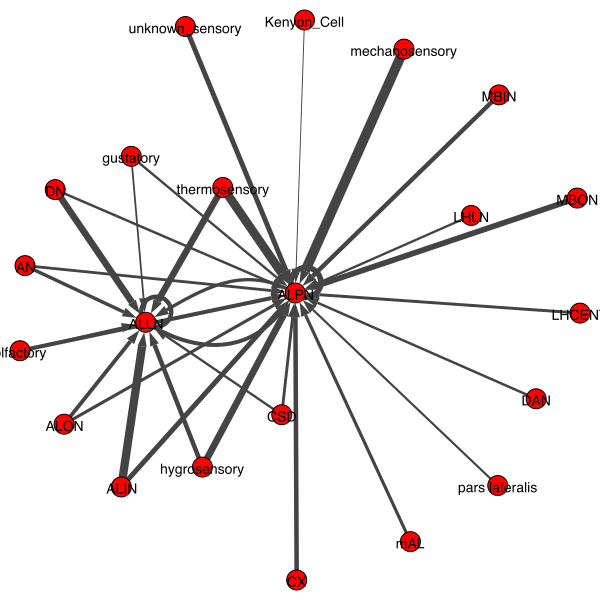

In [89]:
ig.plot(class_g, vertex_label=class_g.vs[:]['name'])

In [14]:
type_syns = pd.DataFrame(AL_syns.groupby(['pre_type', 'post_type']).syn_count.mean().reset_index()

In [15]:
type_syns.sort_values('syn_count', ascending=False, inplace=True)

In [16]:
tuples = [tuple(x) for x in type_syns.values[:40]]
type_g = ig.Graph.TupleList(tuples, directed = True, edge_attrs=['weight'])
type_g.es['width'] = [x['weight']*20 for x in type_g.es]

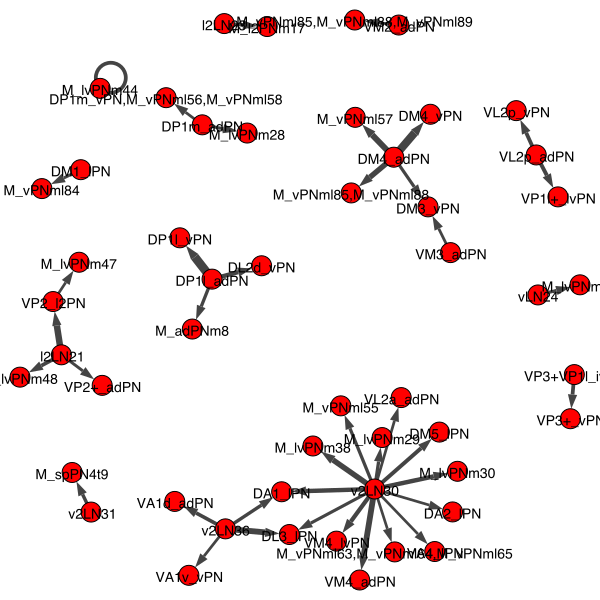

In [17]:
ig.plot(type_g, vertex_label=type_g.vs[:]['name'])

In [18]:
tuples = [tuple(x) for x in AL_syns.values]
Gm = ig.Graph.TupleList(tuples, directed = True, edge_attrs = ['weight', 'pre_class', 'post_class', 'pre_type', 'post_type'])

In [19]:
class_list = np.asarray([label_df.loc[x['name'], 'cell_class'] for x in list(Gm.vs)])
type_list = np.asarray([label_df.loc[x['name'], 'hemibrain_type'] for x in list(Gm.vs)])

In [20]:
Gm.vs[:]['cell_class'] = class_list
Gm.vs[:]['cell_type'] = type_list

I'm gonna choose v2LN36

In [95]:
type_syns

,pre_type,post_type,syn_count
1223,DP1l_adPN,DP1l_vPN,0.438095
1049,DM4_adPN,DM4_vPN,0.401056
6600,l2LN21,VP2_l2PN,0.324474
1073,DM4_adPN,M_vPNml57,0.298391
8962,v2LN36,DL3_lPN,0.293349
...,...,...,...
3483,ORN_DC2,lLN2F_a,0.001005
3639,ORN_DP1l,lLN2T_c,0.001005
1592,M_adPNm3,lLN2T_c,0.001005
4419,VA7l_adPN,lLN2F_a,0.001003


In [21]:
l2ln_syns = type_syns[np.logical_or(type_syns.pre_type.str.contains('v2LN36'),
                                    type_syns.post_type.str.contains('v2LN36'))]

In [22]:
l2ln_syns.sort_values('syn_count', ascending=False, inplace=True)

/var/folders/6x/5lwmcqxs2kq4j9b3q_2bk1j00000gq/T/ipykernel_3296/1476025669.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l2ln_syns.sort_values('syn_count', ascending=False, inplace=True)


In [97]:
tuples = [tuple(x) for x in l2ln_syns[l2ln_syns.syn_count>.005].values]
l2ln_g = ig.Graph.TupleList(tuples, directed = True, edge_attrs = ['weight'])
l2ln_g.es['width'] = [x['weight']*20 for x in l2ln_g.es]

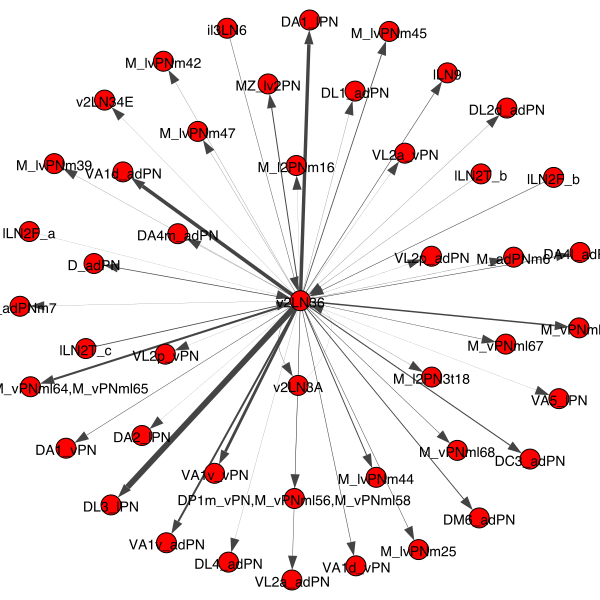

In [98]:
ig.plot(l2ln_g, vertex_label=l2ln_g.vs[:]['name'])